In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hn2016_falwa.oopinterface import QGField
import xarray as xr
import os
import glob
import cartopy.crs as ccrs
from dask.distributed import Client, LocalCluster

In [3]:
cluster = LocalCluster(host='195.113.23.121')#, n_workers=4
client = Client(cluster) # 
client

/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37183 instead
  warnings.warn(


Client Scheduler: tcp://195.113.23.121:41993 Dashboard: http://195.113.23.121:37183/status,Cluster Workers: 8 Cores: 64 Memory: 503.57 GiB


In [4]:
client.dashboard_link

'http://195.113.23.121:37183/status'

In [3]:
inpath = '/mnt/nas4.meop2/meop40.data.model/CMAM/0A.daily/'
inpath = '/mnt/data02/model/CMAM/0A.daily/'

ds_ls = []
for sel_var in ['ua','va','ta']:
    infiles = os.path.join(inpath, 
                           sel_var,
                           f"{sel_var}_6hrPlev_CMAM_CMAM30-SD_r1i1p1_*18.nc") #  exclude files starting with o
    print(infiles)
    ds_temp = xr.open_mfdataset(infiles, concat_dim = 'time', 
                           parallel = True, combine='nested',
                           data_vars='minimal', coords='minimal', 
                            compat='override')#.persist()
    ds_ls.append(ds_temp)

ds = xr.merge(ds_ls)   
ds['plev'] = ds['plev']/100.
ds['plev'].attrs['units'] = 'hPa'
#ds = ds.reindex(latitude=ds.latitude[::-1])
#ds = ds.reindex(level=ds.level[::-1])
xlon = ds.lon.values
ylat= ds.lat.values
plev = ds.plev.values
nlon = xlon.size
nlat = ylat.size
nlev = plev.size
#glob.glob(outpath)

/mnt/data02/model/CMAM/0A.daily/ua/ua_6hrPlev_CMAM_CMAM30-SD_r1i1p1_*18.nc
/mnt/data02/model/CMAM/0A.daily/va/va_6hrPlev_CMAM_CMAM30-SD_r1i1p1_*18.nc
/mnt/data02/model/CMAM/0A.daily/ta/ta_6hrPlev_CMAM_CMAM30-SD_r1i1p1_*18.nc


In [33]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 48, lon: 96, plev: 63, time: 46720)
Coordinates:
  * time       (time) object 1979-01-01 00:00:00 ... 2010-12-31 18:00:00
  * plev       (plev) float64 1e+03 925.0 850.0 800.0 ... 0.0015 0.001 0.0007
  * lat        (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon        (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1460, 2), meta=np.ndarray>
    plev_bnds  (plev, bnds) float64 dask.array<chunksize=(63, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(48, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    ua         (time, plev, lat, lon) float32 dask.array<chunksize=(1460, 63, 48, 96), meta=np.ndarray>
    va         (time, plev, lat, lon) float32 dask.array<chunksize=(1460, 63, 48, 96), meta=np.ndarray>
    ta         (time, plev, lat, lon) float32 dask.array<chunksize=(1460, 63, 48, 96), meta=np.ndarray>

In [4]:
clat = np.cos(np.deg2rad(ylat))     # cosine latitude
p0 = 1000.                          # surface pressure [hPa]
kmax = 49                           # number of grid points for vertical extrapolation (dimension of height)
dz = 1000.                          # differential height element
height = np.arange(0,kmax)*dz       # pseudoheight [m]
dphi = np.diff(ylat)[0]*np.pi/180.     # differential latitudinal element
dlambda = np.diff(xlon)[0]*np.pi/180.  # differential latitudinal element
hh = 7000.                          # scale height
cp = 1004.                          # heat capacity of dry air
rr = 287.                           # gas constant
omega = 7.29e-5                     # rotation rate of the earth
aa = 6.378e+6                       # earth radius
prefactor = np.array([np.exp(-z/hh) for z in height[1:]]).sum() # integrated sum of density from the level
                                                                #just above the ground (z=1km) to aloft
npart = nlat                        # number of partitions to construct the equivalent latitude grids
maxits = 100000                     # maximum number of iteration in the SOR solver to solve for reference state
tol = 1.e-5                         # tolerance that define convergence of solution
rjac = 0.95                         # spectral radius of the Jacobi iteration in the SOR solver.              
jd = nlat//2+1                      # (one plus) index of latitude grid point with value 0 deg
                                    # This is to be input to fortran code. The index convention is different.

# Vectorized functions

In [32]:
def QGField_uref_wrapper(uu, vv, tt):
    #print(uu.shape)
    qgfield_object = QGField(xlon, ylat, plev, uu, vv, tt)
    _, uref, _ = \
        qgfield_object.compute_reference_states(northern_hemisphere_results_only=False)
    #print(uref.shape)
    return uref

def QGField_interpolation_wrapper(uu, vv, tt):
    #print(uu.shape)
    qgfield_object = QGField(xlon, ylat, plev, uu, vv, tt)
    
    _, interpolated_u, interpolated_v, \
       interpolated_theta, _ = qgfield_object.interpolate_fields()
    return interpolated_u#, interpolated_v, interpolated_theta
    #lwa[tstep, :, :, :] \
    #    = qgfield_object.compute_lwa_and_barotropic_fluxes(northern_hemisphere_results_only=False)
    
def QGField_lwa_wrapper(uu, vv, tt):
    qgfield_object = QGField(xlon, ylat, plev, uu, vv, tt)

    *_, lwa = qgfield_object.compute_lwa_and_barotropic_fluxes(northern_hemisphere_results_only=False)
    return lwa

def QGField_wrapper(uu, vv, tt):
    #print(uu.shape)
    qgfield_object = QGField(xlon, ylat, plev, uu, vv, tt)
           
    _, uref, _ = \
        qgfield_object.compute_reference_states(northern_hemisphere_results_only=False)
    _, interpolated_u, _, \
       _, _ = qgfield_object.interpolate_fields()
    *_, lwa = qgfield_object.compute_lwa_and_barotropic_fluxes(northern_hemisphere_results_only=False)
        
    #print(uref.shape)
    return uref, interpolated_u, lwa

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


# UREF

In [34]:
output_sizes = dict(height = kmax)#time = ds.time.shape[0])# , longitude = 1)
i_c_d = ['plev','lat','lon']
o_c_d = ['height','lat']
uref_xa = xr.apply_ufunc(QGField_uref_wrapper, ds['ua'], ds['va'], ds['ta'],
                         vectorize=True,\
                         input_core_dims = [i_c_d, i_c_d, i_c_d], \
                         output_core_dims = [o_c_d], 
                         output_dtypes = [ds['ua'].dtype],
                         exclude_dims=set(("lon",)), 
                         #dask_gufunc_kwargs = dict(output_sizes), 
                         output_sizes = output_sizes,
                         dask = 'parallelized'
                         )#.compute()
uref_xa['height'] = height
uref_xa

<ipython-input-34-06a189ee9365>:4: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  uref_xa = xr.apply_ufunc(QGField_uref_wrapper, ds['ua'], ds['va'], ds['ta'],


<xarray.DataArray (time: 46720, height: 49, lat: 48)>
dask.array<transpose, shape=(46720, 49, 48), dtype=float32, chunksize=(1460, 49, 48), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1979-01-01 00:00:00 ... 2010-12-31 18:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * height   (height) float64 0.0 1e+03 2e+03 3e+03 ... 4.6e+04 4.7e+04 4.8e+04

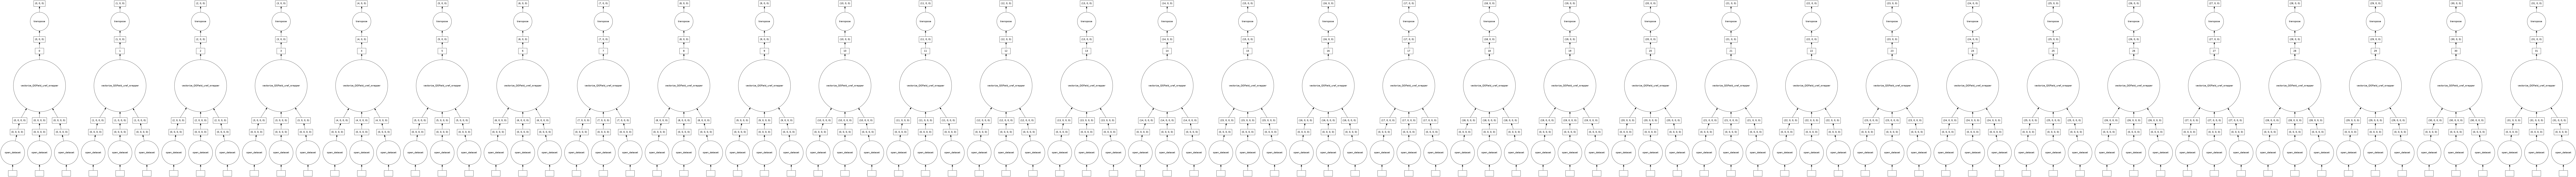

In [7]:
uref_xa.data.visualize()

In [8]:
out_var = 'uref'
uref_xa.name = out_var
outfile = os.path.join(inpath, 
                       out_var,
                       'logH',
                       f"{out_var}_6hrlogH_CMAM_CMAM30-SD_r1i1p1_19790101-20101231.zarr")
print(outfile)
uref_xa.to_dataset().to_zarr(outfile, mode = "w-", consolidated=True)#.to_netcdf(outfile)

/mnt/data02/model/CMAM/0A.daily/uref/logH/uref_6hrlogH_CMAM_CMAM30-SD_r1i1p1_19790101-20101231.zarr


# all

In [35]:
i_c_d = ['plev','lat','lon']
o_c_d = ['height','lat']
o_c_d_int = ['height','lat','lon']
#o_c_d_lwa = ['height','lat','lon']
output_sizes = dict(height = kmax)#time = ds.time.shape[0])# , longitude = 1)

u_int = xr.apply_ufunc(QGField_wrapper, ds['ua'], ds['va'], ds['ta'],
                         vectorize=True,\
                         input_core_dims = [i_c_d, i_c_d, i_c_d], \
                         output_core_dims = [o_c_d, o_c_d_int, o_c_d_int], 
                         output_dtypes = [ds['ua'].dtype]*3,
                         #exclude_dims=set(("longitude",)), 
                         dask_gufunc_kwargs = dict(output_sizes = output_sizes), 
                         dask = 'parallelized'
                         )#.compute()
#u_int['height'] = height
outvar_ls = ["uref", "ua_int", "lwa"]
for arr, outvar in zip(u_int, outvar_ls):
    arr.name = outvar
u_int_all = xr.merge(u_int)
u_int_all

<xarray.Dataset>
Dimensions:  (height: 49, lat: 48, lon: 96, time: 46720)
Coordinates:
  * time     (time) object 1979-01-01 00:00:00 ... 2010-12-31 18:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Dimensions without coordinates: height
Data variables:
    uref     (time, height, lat) float32 dask.array<chunksize=(1460, 49, 48), meta=np.ndarray>
    ua_int   (time, height, lat, lon) float32 dask.array<chunksize=(1460, 49, 48, 96), meta=np.ndarray>
    lwa      (time, height, lat, lon) float32 dask.array<chunksize=(1460, 49, 48, 96), meta=np.ndarray>

In [31]:
outfile = os.path.join(inpath, 
                       f"QGFields_6hrlogH_CMAM_CMAM30-SD_r1i1p1_19790101-20101231.zarr")
print(outfile)
u_int_all.to_zarr(outfile, mode = "w", consolidated=True)#.to_netcdf(outfile)

/mnt/data02/model/CMAM/0A.daily/QGFields_6hrlogH_CMAM_CMAM30-SD_r1i1p1_19790101-20101231.zarr


KeyboardInterrupt: 